In [16]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm

sns.set_style('darkgrid')

In [209]:
def generate_planted_clique(n, k):
    g = nx.erdos_renyi_graph(n, 1/2)
    K = np.random.choice(np.arange(n), size=k, replace=False)
    g.add_edges_from([(K[i],K[j]) for i in range(k) for j in range(i+1,k)])
    return g, K

def algorithm_1(g, k, clean=False):
    n = len(g.nodes)
    A = nx.adjacency_matrix(g).todense()
    W = 2*A - 1
    W -= np.diag(np.diag(W))
    _, U = np.linalg.eigh(W)
    u = U[:,n-1].ravel()
    _, K_tilde = np.where(np.argsort(np.abs(u)) >= n - k)
    
    K_hat = K_tilde
    if clean:
        K_hat = [v for v in g.nodes if g.subgraph(list(K_tilde) + [v]).degree()[v] >= 3*k/4]
    return K_hat

# (A)

In [210]:
num_trials = 10
#num_trials = 1000

data = list()
for n, k_range in tqdm([
    (100, range(10, 91, 10)),
    (200, range(10, 191, 20)),
    (500, range(10, 451, 20)),
]):
    for k in tqdm(k_range):
        for m in trange(num_trials):
            g, K = generate_planted_clique(n, k)
            K_hat = algorithm_1(g, k, clean=False)
            data.append({
                'n': n,
                'k': k,
                'e_bit': len(set(K) - set(K_hat)) / len(set(K)),
                'e_block': int(set(K) != set(K_hat)),
            })

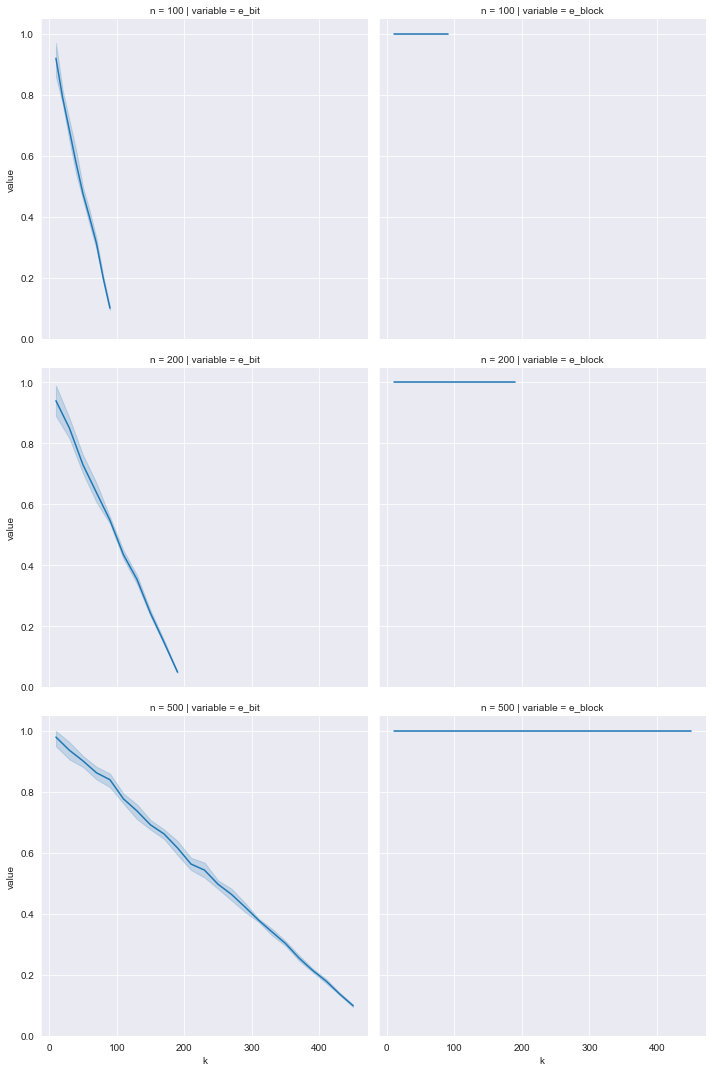

In [211]:
df = (pd.DataFrame(data)
     .melt(id_vars=['n', 'k'], value_vars=['e_bit', 'e_block']))
sns.relplot(
    data=df, x='k', y='value',
    row='n', col='variable',
    kind='line',
)

# (B)

In [212]:
num_trials = 10
#num_trials = 1000

data = list()
for n, k_range in tqdm([
    (100, range(10, 91, 10)),
    (200, range(10, 191, 20)),
    (500, range(10, 451, 20)),
]):
    for k in tqdm(k_range):
        for m in trange(num_trials):
            g, K = generate_planted_clique(n, k)
            K_hat = algorithm_1(g, k, clean=True)
            data.append({
                'n': n,
                'k': k,
                'e_bit': len(set(K) - set(K_hat)) / len(set(K)),
                'e_block': int(set(K) != set(K_hat)),
            })

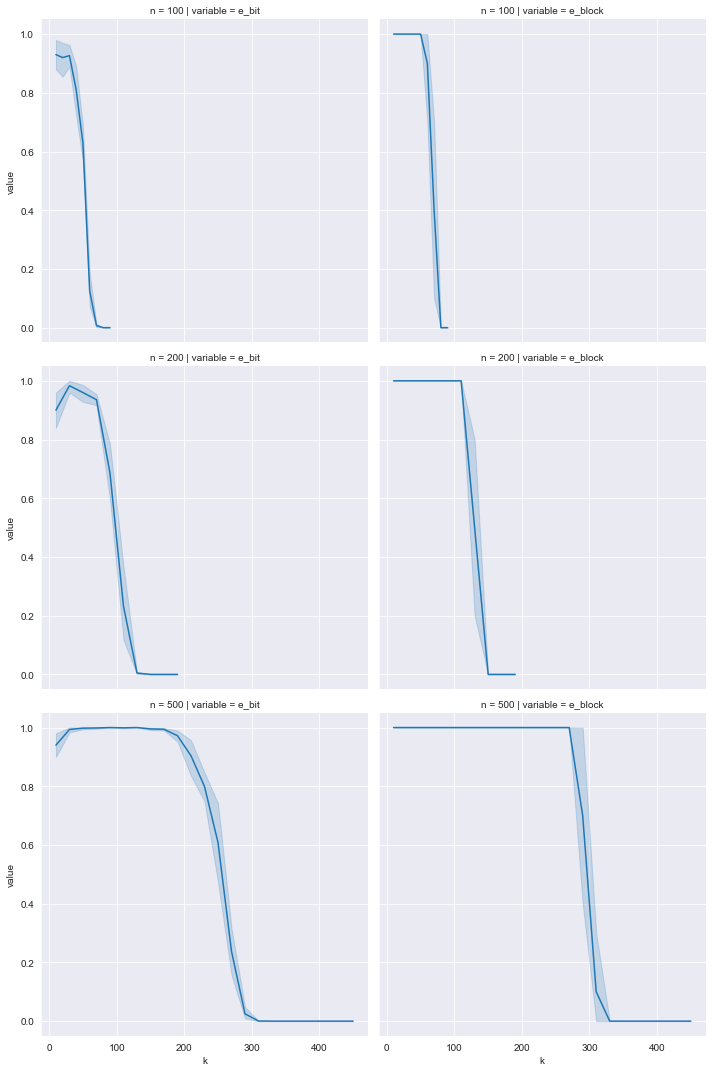

In [213]:
df = (pd.DataFrame(data)
     .melt(id_vars=['n', 'k'], value_vars=['e_bit', 'e_block']))
sns.relplot(
    data=df, x='k', y='value',
    row='n', col='variable',
    kind='line',
)

# (C)

In [69]:
import itertools

def algorithm_2(g, k):
    c = k / np.sqrt(len(g.nodes))
    s = int(2.0 * np.log2(10.0 / c) + 2.0)+1
    for S in itertools.combinations(g.nodes, s):
        N_star = [
            v for v in g.nodes
            if v not in S
            and all([(v, u) in g.edges for u in S])
        ]
        if len(N_star) == 0:
            continue
        Q_s = algorithm_1(g.subgraph(N_star), k, clean=True)
        Q = list(Q_s) + list(S)
        if len(g.subgraph(Q).edges) == len(Q) * (len(Q) - 1) / 2:
            return Q
    return np.random.choice(g.nodes, size=k, replace=False)

In [ ]:
num_trials = 10
#num_trials = 1000

data = list()
for n, k_range in tqdm([
    (500, range(10, 101, 20)),
]):
    for k in tqdm(k_range):
        for m in trange(num_trials):
            g, K = generate_planted_clique(n, k)
            K_hat = algorithm_2(g, k)
            data.append({
                'n': n,
                'k': k,
                'e_bit': len(set(K) - set(K_hat)) / len(set(K)),
                'e_block': int(set(K) != set(K_hat)),
            })

In [ ]:
df = (pd.DataFrame(data)
     .melt(id_vars=['n', 'k'], value_vars=['e_bit', 'e_block']))
sns.relplot(
    data=df, x='k', y='value',
    row='n', col='variable',
    kind='line',
)